<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week11/Pytorch_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting house prices with neural networks

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

### loading the data

In [48]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week11/data/housing_dataset.csv")
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
raw_data.shape

(1460, 81)

### Extracting the numeric columns

In [50]:
raw_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [51]:
numeric_columns = list(raw_data.columns[(raw_data.dtypes==np.int64) |
                 (raw_data.dtypes==np.float64)])
print(numeric_columns, "\n", len(numeric_columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
 38


Set `SalesPrice` as the last index, since it is the value we want to predict.

In [52]:
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

We do not need the `Id` column.

In [53]:
numeric_columns.remove('Id')

Now we extract the numeric data.

In [54]:
numeric_data = raw_data[numeric_columns]
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let's deal with the missing values in the data.

In [55]:
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
nan_columns

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

We simply replace them with zero.

In [56]:
numeric_data['LotFrontage'] = numeric_data['LotFrontage'].fillna(0)
numeric_data['MasVnrArea'] = numeric_data['MasVnrArea'].fillna(0)
numeric_data['GarageYrBlt'] = numeric_data['GarageYrBlt'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

let's split the data for training and test!

In [57]:
from sklearn.model_selection import train_test_split
numeric_data_train, numeric_data_test = train_test_split(numeric_data, test_size=0.1)

### Normalizing the data
Before training our linear regression model, we have to normalize the data. We do this by subtracting each column from its minimum value and then dividing it by the difference between maximum and minimum.

In [58]:
# saving max, min for each column
maxs, mins = dict(), dict()

In [59]:
for col in numeric_data:
    maxs[col] = numeric_data_train[col].max()
    mins[col] = numeric_data_train[col].min()

In [60]:
numeric_data_train = (numeric_data_train - numeric_data_train.min()) / (numeric_data_train.max() - numeric_data_train.min())

## Building a Linear Regression model

In [61]:
import torch
import torch.nn as nn

In [62]:
numeric_x_columns = list(numeric_data_train.columns)
numeric_x_columns.remove("SalePrice")
X_train_df = numeric_data_train[numeric_x_columns]
y_train_df = pd.DataFrame(numeric_data_train["SalePrice"])

Now we have to convert the data into torch tensors. A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type. It's very similar to arrays in `NumPy`.

In [63]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float)
y_train = torch.tensor(y_train_df.values, dtype=torch.float)

In [64]:
print(X_train.size(), y_train.size())

torch.Size([1314, 36]) torch.Size([1314, 1])


### Defining a model with pytorch
A model is always defined as a class in pytorch. It should have a `__init__` function in which you define the layers of your network. It also should have a `forward` function (method) that basically defines the forward pass on the network.

For the beggining, let's start with a single layer network.

In [65]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        y_pred = self.activation(self.linear1(x))
        y_pred = self.linear2(y_pred)
        return y_pred

In [66]:
D_in, D_out = X_train.shape[1], y_train.shape[1]

In [67]:
# defining the first model: an instance of the class "Net"
model1 = Net(D_in, 500, D_out)

The next steps is to define the __loss criterion__ and the __optimizer__ for the network. That is, we have to define the loss function we want to optimize during training and also the optimization method we are going to use, e.g, SGD, etc.

In [68]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

Now, we are ready to do the training. We can simply do this by a for loop over the number of iterations. The training has 3 main steps:
- A forward pass to compute the prediction for the current data point (batch).
- computing the loss for the current prediction.
- A backward pass to compute the gradient of the loss with respect to the weight of the network.
- Finaly, updating the weights of the network (`optimizer.step()`).

Note that in each backward pass pytorch saves the gradient for all of the parameters. Therefore it is important to replace the old gradient values with zero in the beggining of each iteration, otherwise the gradients will be accumulated during the iterations!

In [69]:
# we need to normalize the test data with the min and max value
# from the training data
for col in numeric_data_test.columns:
    numeric_data_test[col] = (numeric_data_test[col] - mins[col]) / (maxs[col] - mins[col])

In [70]:
# normalize the test data 
y_test_df = pd.DataFrame(numeric_data_test["SalePrice"])
y_test = torch.tensor(y_test_df.values, dtype=torch.float)
x_test_df = numeric_data_test[numeric_x_columns]
x_test = torch.tensor(x_test_df.values, dtype=torch.float)

In [71]:
losses1 = []
losses1_test = []
for t in range(500):
    y_pred = model1(X_train)
    
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # test loss
    losses1_test.append(criterion(model1(x_test), y_test).item())

0 130.5743408203125
1 1294.43505859375
2 11896.84765625
3 6695.265625
4 43.54777908325195
5 32.55015182495117
6 26.683879852294922
7 23.50665283203125
8 21.738168716430664
9 20.708471298217773
10 20.066730499267578
11 19.629928588867188
12 19.30201530456543
13 19.03306770324707
14 18.79705810546875
15 18.579790115356445
16 18.373620986938477
17 18.17457389831543
18 17.98070526123047
19 17.791189193725586
20 17.605419158935547
21 17.422754287719727
22 17.242847442626953
23 17.06535530090332
24 16.890451431274414
25 16.717634201049805
26 16.546937942504883
27 16.378273010253906
28 16.211536407470703
29 16.046537399291992
30 15.883082389831543
31 15.721307754516602
32 15.560848236083984
33 15.402021408081055
34 15.244546890258789
35 15.088231086730957
36 14.93294906616211
37 14.778922080993652
38 14.625255584716797
39 14.47214126586914
40 14.319780349731445
41 14.167791366577148
42 14.016284942626953
43 13.8654203414917
44 13.714788436889648
45 13.564779281616211
46 13.415143013000488
47 

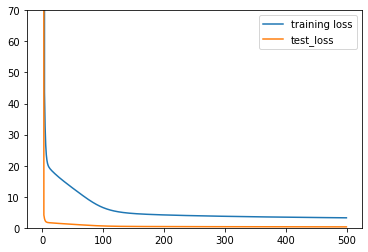

In [72]:
plt.plot(losses1, label="training loss")
plt.plot(losses1_test, label="test_loss")
plt.ylim(top=70, bottom=0.0)
plt.legend()

Now let's try a new model with more neurons in the hidden layer.

In [73]:
model2 = Net(D_in, 1000, D_out)

In [74]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

In [75]:
losses2 = []

for t in range(500):
    y_pred = model2(X_train)
    
    loss = criterion(y_pred, y_train)
    # print(t, loss.item())
    losses2.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

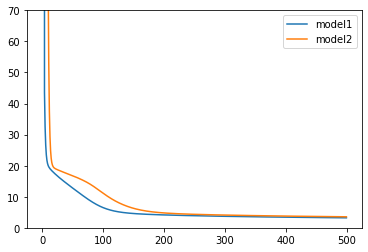

In [76]:
plt.plot(losses1, label="model1")
plt.plot(losses2, label="model2")
plt.ylim([0, 70])
plt.legend()

Let's compare the MSE loss on the test data

In [77]:
# prediction for model 1
model1_pred = model1(x_test)
print("MSE loss for model1: ", criterion(model1_pred, y_test))
# prediction for model 2
model2_pred = model2(x_test)
print("MSE loss for model2: ", criterion(model2_pred, y_test))


MSE loss for model1:  tensor(0.3020, grad_fn=<MseLossBackward0>)
MSE loss for model2:  tensor(0.3095, grad_fn=<MseLossBackward0>)


## Now it is your turn!
### Exercises

1- Let's get back to model1. This time try to train it with a new optimizer. Try the Adam optimizer (which has shown to be faster than SGD for non-convex functions) and compare the trainig loss curve with SGD. Plot the training loss for the model trained with SGD and Adam optimizer.

Note1: Use `torch.optim.Adam(model1.parameters(), lr=...)`

Note2: If you are interested, check [this nice post](https://ruder.io/optimizing-gradient-descent/index.html) on differen gradient descent optimization algorithms.

2- This time we want to build a new model with a new architecture. Specifically, we want to train a network with 3 hidden layers on the data. You can use the following code to build the architecture. Use the values 500, 1000, 200 for H1, H2, and H3 respectively. Train this new network on the same training data and compare it with the model1 we built above.

```
class Net_new(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net_new, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        self.activation = nn.ReLU()

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))
        y_pred = self.activation(self.linear2(y_pred))
        y_pred = self.activation(self.linear3(y_pred))
        y_pred = self.linear4(y_pred)
        return y_pred
```